In [1]:
import torch
from torch import nn
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
from random import randint
from IPython.display import clear_output

import numpy as np
import pylab as pl

from src import *

In [2]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 8     # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5

torch.backends.cudnn.benchmark = True # Speeds up things

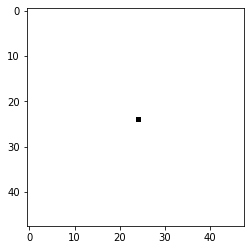

In [3]:
# Starting state
def generator(n, device):
    return make_seed(n, N_CHANNELS-1, IMAGE_SIZE, alpha_channel=3, device=device)

pool = SamplePool(POOL_SIZE, generator)
imshow(pool[0])

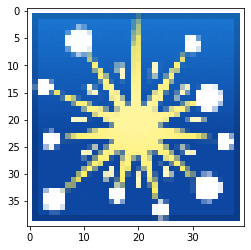

In [4]:
# Imports the target emoji
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [5]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target = target.to(device)

In [6]:
growing = NeuralCA().to(device)
folder = "Pretrained_models/firework/Classical_NCAs/"
growing.load(folder + "firework_growing_64_96.pt")

Successfully loaded model!


In [7]:
new_CA = NeuralCA(device=device)
new_CA.load(folder + "firework_growing_64_96.pt")

L_perturbation = NCADistance(growing, new_CA)
new_CA.end_step_loss = L_perturbation

L_target = NCALoss(pad(target, TARGET_PADDING), alpha_channels=[3])

criterion = CombinedLoss([L_target], [ConstantWeight(64)])

Successfully loaded model!


In [ ]:
# Train the model
for param in growing.parameters():
    param.requires_grad = False

wandb.init(mode="disabled")
optimizer = torch.optim.Adam(new_CA.parameters(), lr=2e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.3)

new_CA.train_CA(optimizer, criterion, pool, n_epochs=120, skip_update=1,
               scheduler=scheduler, kind="persist", skip_damage=1, batch_size=10)

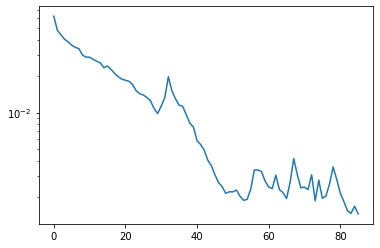

In [10]:
pl.plot(new_CA.losses)
pl.yscale("log")

In [16]:
ruler.cosine_similarity(growing, new_CA)

tensor(0.9587, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


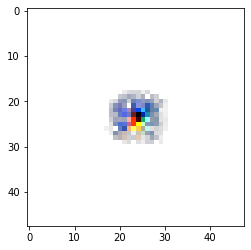

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


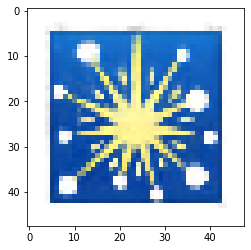

In [26]:
x = make_seed(1, 15, 48, 1, 3)

x = growing.evolve(x.cuda(), 10)

imshow(x[0])

imshow(new_CA.evolve(x.cuda(), 200)[0].cpu())